In [50]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [51]:
import pandas as pd

In [52]:
df_final=pd.read_csv("../../data/silver/master_weather_merged/toronto_master_weather_merged.csv")

In [53]:
train_df = df_final[df_final['ds'] < '2024-01-01'].copy()
test_df = df_final[df_final['ds'] >= '2024-01-01'].copy()

print(f"Training Weeks: {len(train_df)}")
print(f"Testing Weeks: {len(test_df)}")

Training Weeks: 521
Testing Weeks: 93


In [54]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False)

In [55]:
m.add_country_holidays(country_name='CA')

In [56]:
print("Training Prophet model...")
m.fit(train_df[['ds', 'y']])

09:31:20 - cmdstanpy - INFO - Chain [1] start processing
09:31:20 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model...


In [57]:
future = m.make_future_dataframe(periods=len(test_df), freq='W-MON')
forecast = m.predict(future)

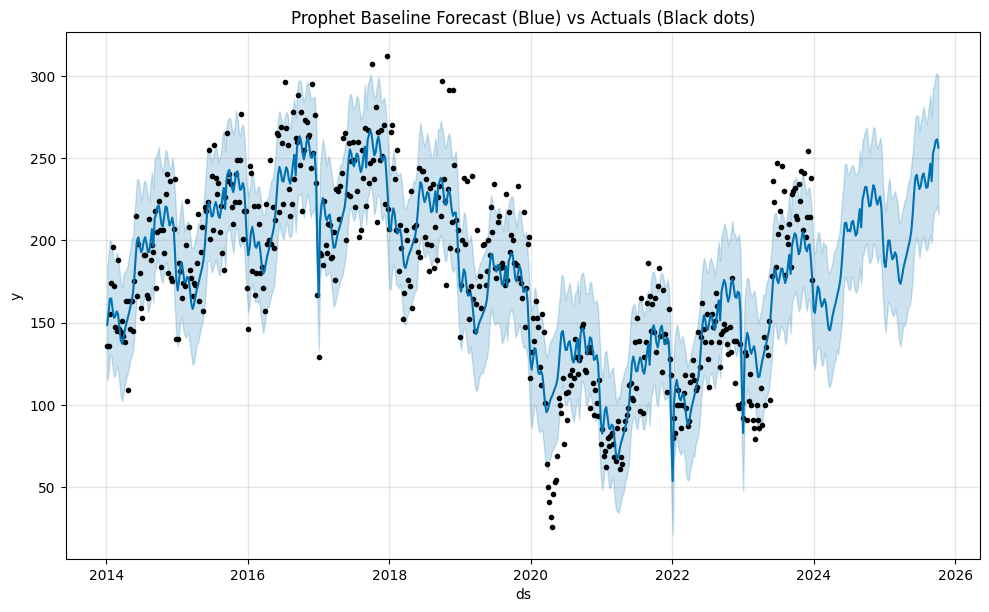

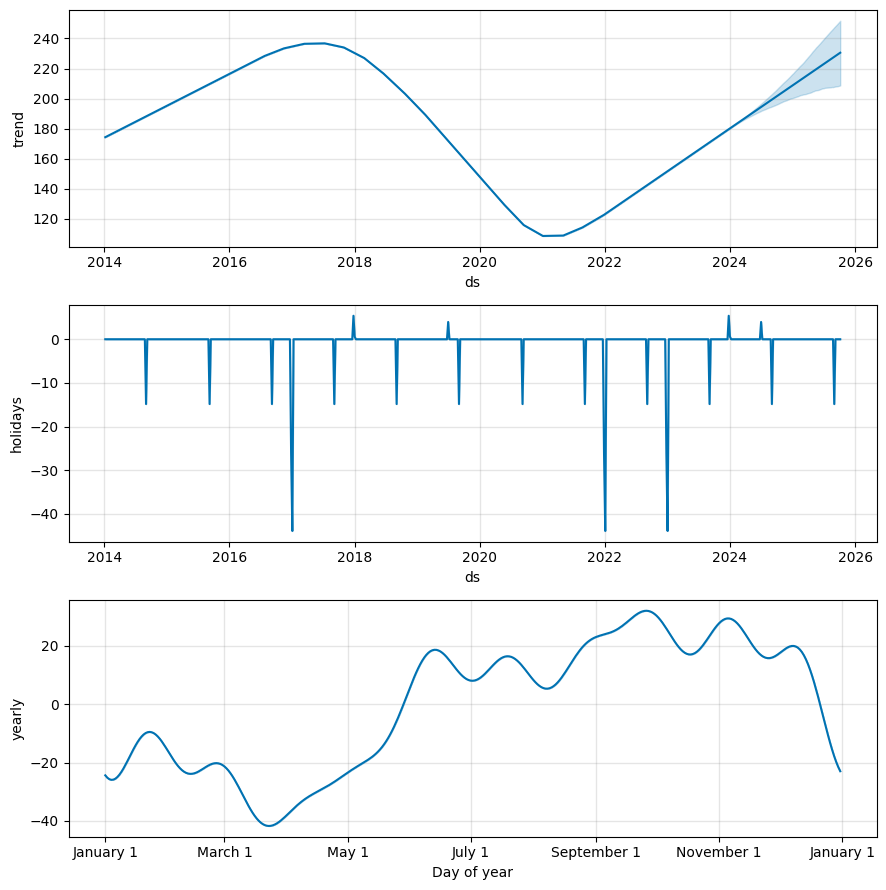

In [58]:

fig1 = m.plot(forecast)
plt.title("Prophet Baseline Forecast (Blue) vs Actuals (Black dots)")
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

In [59]:
train_pred = m.predict(train_df[['ds']])
train_df['prophet_pred'] = train_pred['yhat'].values

In [60]:
train_df['residual'] = train_df['y'] - train_df['prophet_pred']

In [61]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [62]:
features = ['national_index', 'is_holiday', 'precip_mm', 'snow_depth_cm', 'min_temp']
target = 'residual'

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.01, 
    max_depth=5,
    random_state=42
)

In [64]:
xgb_model.fit(train_df[features], train_df[target])
train_correction = xgb_model.predict(train_df[features])
mae_residual = mean_absolute_error(train_df['residual'], train_correction)
print(f"XGBoost MAE on Residuals: {mae_residual:.2f}")

XGBoost MAE on Residuals: 1.71


Generating Final Hybrid Forecast...
Baseline MAE: 26.69
Hybrid MAE:   31.95
Improvement:  -19.7%


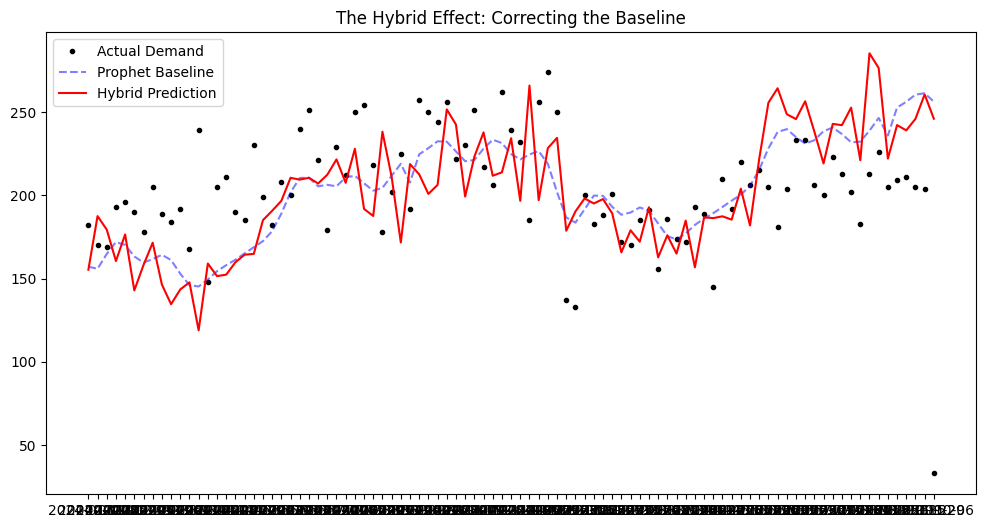

In [65]:
print("Generating Final Hybrid Forecast...")

# 1. Get Prophet Baseline for Test Set (2024-2025)
future_test = m.predict(test_df[['ds']])
test_df['prophet_pred'] = future_test['yhat'].values

# 2. Get XGBoost Correction for Test Set
# It looks at the weather/national data for 2024-2025 to predict shocks
test_df['xgb_correction'] = xgb_model.predict(test_df[features])

# 3. Combine: Final = Baseline + Correction [cite: 133]
test_df['final_prediction'] = test_df['prophet_pred'] + test_df['xgb_correction']

# 4. Compare Accuracy (Baseline vs Hybrid)
mae_base = mean_absolute_error(test_df['y'], test_df['prophet_pred'])
mae_hybrid = mean_absolute_error(test_df['y'], test_df['final_prediction'])

print(f"Baseline MAE: {mae_base:.2f}")
print(f"Hybrid MAE:   {mae_hybrid:.2f}")
print(f"Improvement:  {((mae_base - mae_hybrid) / mae_base) * 100:.1f}%")

# 5. Visualize the "Correction Effect"
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'], 'k.', label='Actual Demand')
plt.plot(test_df['ds'], test_df['prophet_pred'], 'b--', alpha=0.5, label='Prophet Baseline')
plt.plot(test_df['ds'], test_df['final_prediction'], 'r-', label='Hybrid Prediction')
plt.legend()
plt.title("The Hybrid Effect: Correcting the Baseline")
plt.show()